# A List of Specimens For all Phenoscape Taxonomy



In [90]:
from pyspark.sql.functions import col, isnull, lower, split, sum, regexp_replace
from pyspark.sql.types import IntegerType

In [21]:
# Load CSV after placing it on HDFS
ps_tax = (sqlContext
           .read
           .option("header", "true")
           .csv("/home/mjcollin/queryResults_phenoscape_taxonomy.csv")
           .cache()
           )

In [22]:
print(ps_tax.count())
ps_tax.printSchema()
ps_tax.show(3)

6727
root
 |-- matrix_taxon: string (nullable = true)
 |-- vto: string (nullable = true)
 |-- vto_label: string (nullable = true)

+--------------------+--------------------+--------------------+
|        matrix_taxon|                 vto|           vto_label|
+--------------------+--------------------+--------------------+
|Scyliorhinus retifer|http://purl.oboli...|Scyliorhinus retifer|
|     Mustelus laevis|http://purl.oboli...|   Mustelus mustelus|
| Cynocephalus volans|http://purl.oboli...| Cynocephalus volans|
+--------------------+--------------------+--------------------+
only showing top 3 rows



Check to see how distinct things are by vto_label

In [23]:
(ps_tax
.groupBy(col("vto_label"))
.count()
.orderBy(col("count"), ascending=False)
).show(10, truncate=False)

+-------------------------+-----+
|vto_label                |count|
+-------------------------+-----+
|Kassina senegalensis     |10   |
|Plicofollis argyropleuron|9    |
|Netuma thalassina        |9    |
|Chrysichthys auratus     |6    |
|Eoherpeton watsoni       |5    |
|Brustiarius solidus      |5    |
|Whatcheeria deltae       |5    |
|Panderichthys rhombolepis|5    |
|Greererpeton burkemorani |5    |
|Crassigyrinus scoticus   |5    |
+-------------------------+-----+
only showing top 10 rows



We need to trim this a bit to avoid multiple joined rows with a distinct. Also, set up the columns to make the join a bit shorter. Note that indexing past the lenght of an array conveniently results in a NULL, not an error.

In [47]:
ps_tax_split = (ps_tax
.select(col("vto"), col("vto_label"),
        lower(split(col("vto_label"), " ")[0]).alias("tok1"),
        lower(split(col("vto_label"), " ")[1]).alias("tok2"))
.distinct()
)
print(ps_tax_split.count())
ps_tax_split.show(3)

5918
+--------------------+--------------------+-------------+----------+
|                 vto|           vto_label|         tok1|      tok2|
+--------------------+--------------------+-------------+----------+
|http://purl.oboli...| Hemibagrus guttatus|   hemibagrus|  guttatus|
|http://purl.oboli...|Nipponocypris tem...|nipponocypris|temminckii|
|http://purl.oboli...|      Ameiurus catus|     ameiurus|     catus|
+--------------------+--------------------+-------------+----------+
only showing top 3 rows



Join things up

In [ ]:
idb_df = sqlContext.read.parquet("/guoda/data/idigbio-20171209T023310.parquet")

In [48]:
ps_specimen_list = (ps_tax_split
                   .join(idb_df.select(col("uuid"), col("family"), col("genus"), col("specificepithet"), col("geopoint")), 
                        (col("tok1") == col("genus")) & (col("tok2") == col("specificepithet"))
                         | (col("tok1") == col("family")),
                         "left"
                        )
                    .cache()
                   )
#ps_specimen_list.show(3)

The above join turned out to be about 25 minutes and it was re-calculated a lot. Write out the results and re-load them so they won't be regenerated while summarizing them below.

In [ ]:
(ps_specimen_list
.select(col("vto"), col("vto_label"), col("tok1"), col("tok2"), col("uuid"), 
        col("family"), col("genus"), col("specificepithet"), 
        col("geopoint.lat").alias("lat"),
        col("geopoint.lon").alias("lon"))
.repartition(1)
.write
.mode('overwrite')
.csv("/tmp/pheno_specimen.csv", header=True)
)

In [50]:
pheno_specimen = sqlContext.read.csv("/tmp/pheno_specimen.csv", header=True)

In [51]:
print(pheno_specimen.count())

7203147


In [52]:
pheno_specimen.printSchema()

root
 |-- vto: string (nullable = true)
 |-- vto_label: string (nullable = true)
 |-- tok1: string (nullable = true)
 |-- tok2: string (nullable = true)
 |-- uuid: string (nullable = true)
 |-- family: string (nullable = true)
 |-- genus: string (nullable = true)
 |-- specificepithet: string (nullable = true)
 |-- lat: string (nullable = true)
 |-- lon: string (nullable = true)



How many specimens did we get by taxon?

In [54]:
taxa_counts = (pheno_specimen
 .groupBy(col("genus"), col("specificepithet"))
 .count()
 .orderBy(col("count"), ascending=False)
 ).toPandas()
#.show(100, truncate=False)

In [55]:
taxa_counts.head(50)

,genus,specificepithet,count
0,None,None,267738
1,plethodon,cinereus,116788
2,desmognathus,ochrophaeus,57920
3,bufo,bufo,50825
4,campostoma,anomalum,41826
5,pimephales,notatus,41474
6,semotilus,atromaculatus,40452
7,desmognathus,fuscus,37741
8,lepomis,macrochirus,32457
9,engraulis,mordax,31650


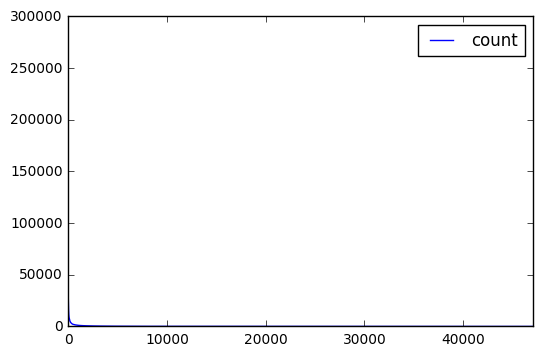

In [36]:
%matplotlib inline
taxa_counts.plot(y="count")

What is present in Phenoscape that didn't join in iDigBio?

In [ ]:
unmatched = (pheno_specimen
.filter(isnull(col("uuid")))
.select(col("vto"), col("tok1"), col("tok2"))
.orderBy(col("vto"))
)
print(unmatched.count())
unmatched.show(100, truncate=False)

Trim things down a bit

In [64]:
fins = sqlContext.read.csv("/home/mjcollin/forelimb-bones-Ontotrace.csv", header=True)
limbs = sqlContext.read.csv("/home/mjcollin/fin-Ontotrace.csv", header=True)

In [100]:
fins.printSchema()

root
 |-- Valid Taxon: string (nullable = true)
 |-- Valid Taxon label: string (nullable = true)
 |-- sesamoid bone of manus: string (nullable = true)
 |-- carpal bone: string (nullable = true)
 |-- metacarpal bone: string (nullable = true)
 |-- humerus: string (nullable = true)
 |-- ulna: string (nullable = true)
 |-- radius bone: string (nullable = true)
 |-- centrale (fore): string (nullable = true)
 |-- ulnare: string (nullable = true)
 |-- phalanx of manus: string (nullable = true)
 |-- intermedium: string (nullable = true)
 |-- radiale: string (nullable = true)



In [101]:
fins = fins.withColumn("vto_short", col("Valid Taxon"))
limbs = limbs.withColumn("vto_short", col("Valid Taxon"))


In [102]:
vtos_w_chars = (fins
                .select(col("Valid Taxon").alias("vto_short_char"))
               .union(limbs.select(col("Valid Taxon").alias("vto_short_char"))
                     )
               .distinct()
               )

In [103]:
vtos_w_chars.head(10
                 )

[Row(vto_short_char='VTO:0003367'),
 Row(vto_short_char='VTO:9031101'),
 Row(vto_short_char='VTO:0002866'),
 Row(vto_short_char='VTO:0081407'),
 Row(vto_short_char='VTO:9020399'),
 Row(vto_short_char='VTO:0052433'),
 Row(vto_short_char='VTO:0035101'),
 Row(vto_short_char='VTO:0047200'),
 Row(vto_short_char='VTO:0056335'),
 Row(vto_short_char='VTO:0059318')]

In [91]:
(pheno_specimen
 .select(col("vto"), regexp_replace(split(col("vto"),"/")[4], "_", ":"))
 .show(4, truncate=False)
)


+------------------------------------------+--------------------------------------+
|vto                                       |regexp_replace(split(vto, /)[4], _, :)|
+------------------------------------------+--------------------------------------+
|http://purl.obolibrary.org/obo/VTO_0044933|VTO:0044933                           |
|http://purl.obolibrary.org/obo/VTO_0002115|VTO:0002115                           |
|http://purl.obolibrary.org/obo/VTO_0002115|VTO:0002115                           |
|http://purl.obolibrary.org/obo/VTO_0001560|VTO:0001560                           |
+------------------------------------------+--------------------------------------+
only showing top 4 rows



In [94]:
restricted_pheno_specimen = (pheno_specimen
 .withColumn("vto_short", regexp_replace(split(col("vto"),"/")[4], "_", ":"))
 .filter((col("lat").isNotNull()))
 .join(vtos_w_chars, col("vto_short_char") == col("vto_short"))
 )

In [95]:
print(restricted_pheno_specimen.count())
restricted_pheno_specimen.show(5, truncate=False)

1857068
+------------------------------------------+----------------------+---------+-------------+------------------------------------+---------+--------+---------------+------------------+------+-----------+--------------+
|vto                                       |vto_label             |tok1     |tok2         |uuid                                |family   |genus   |specificepithet|lat               |lon   |vto_short  |vto_short_char|
+------------------------------------------+----------------------+---------+-------------+------------------------------------+---------+--------+---------------+------------------+------+-----------+--------------+
|http://purl.obolibrary.org/obo/VTO_0007309|Bufo bufo             |bufo     |bufo         |af3926ad-3be8-4a3e-ab77-13977e996ca9|bufonidae|bufo    |bufo           |40.81000000000001 |-80.9 |VTO:0007309|VTO:0007309   |
|http://purl.obolibrary.org/obo/VTO_0007362|Anaxyrus fowleri      |anaxyrus |fowleri      |47b9e6db-b470-4db3-80ef-155e6f6bf

In [114]:
with_chars = (restricted_pheno_specimen
.withColumn("vto_short_spec", col("vto_short"))
.join(fins, fins.vto_short == restricted_pheno_specimen.vto_short, 'left')
.join(limbs, limbs.vto_short == restricted_pheno_specimen.vto_short, 'left')
)

In [115]:
print(with_chars.count())
with_chars.show(3, truncate=False)

1857068
+------------------------------------------+----------------+---------+-------+------------------------------------+---------+--------+---------------+------------------+------+-----------+--------------+--------------+-----------+-----------------+----------------------+-----------+---------------+-------+----+-----------+---------------+------+----------------+-----------+-------+-----------+-----------+-----------------+----------+------------+-------------------+---------+
|vto                                       |vto_label       |tok1     |tok2   |uuid                                |family   |genus   |specificepithet|lat               |lon   |vto_short  |vto_short_char|vto_short_spec|Valid Taxon|Valid Taxon label|sesamoid bone of manus|carpal bone|metacarpal bone|humerus|ulna|radius bone|centrale (fore)|ulnare|phalanx of manus|intermedium|radiale|vto_short  |Valid Taxon|Valid Taxon label|pelvic fin|pectoral fin|pelvic sucking disc|vto_short|
+---------------------------

In [111]:
print(with_chars.columns)

['vto', 'vto_label', 'tok1', 'tok2', 'uuid', 'family', 'genus', 'specificepithet', 'lat', 'lon', 'vto_short', 'vto_short_char', 'Valid Taxon', 'Valid Taxon label', 'sesamoid bone of manus', 'carpal bone', 'metacarpal bone', 'humerus', 'ulna', 'radius bone', 'centrale (fore)', 'ulnare', 'phalanx of manus', 'intermedium', 'radiale', 'vto_short', 'Valid Taxon', 'Valid Taxon label', 'pelvic fin', 'pectoral fin', 'pelvic sucking disc', 'vto_short']


In [120]:
(with_chars
.select(col("vto_short_spec").alias("vto_short"), col("vto_label"), col("tok1"), col("tok2"), col("uuid"), 
        col("family"), col("genus"), col("specificepithet"), 
        col("lat"), col("lon"),
        col("sesamoid bone of manus").alias("char_sesamoid_bone_of_manus"),
        col("carpal bone").alias("char_carpal_bone"),
         col("metacarpal bone").alias("char_metacarpal_bone"),
         col("humerus").alias("char_humerus"),
         col("ulna").alias("char_ulna"),
         col("radius bone").alias("char_radius_bone"),
         col("centrale (fore)").alias("char_centrale_fore"),
         col("ulnare").alias("char_ulnare"),
         col("phalanx of manus").alias("char_phalanx_of_manus"),
         col("intermedium").alias("char_intermedium"),
         col("radiale").alias("char_radiale"),
         col("pelvic fin").alias("char_pelvic_fin"),
         col("pectoral fin").alias("char_pectoral_fin"),
         col("pelvic sucking disc").alias("char_pelvic_sucking_disc")
        )
.repartition(1)
.write
.mode('overwrite')
.csv("/tmp/pheno_specimen_with_chars.csv", header=True)
)